<a href="https://colab.research.google.com/github/AyeshaAnzerBCIT/Multisource/blob/main/eyetracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gcsfs
import pandas as pd

# Initialize GCS file system with authentication
fs = gcsfs.GCSFileSystem(token="Key.json")

# Define the path to the eye-tracking data in GCS
eyetracking_data_path = "eegchild/EEG_extracted/"

# Use GCS to get all .txt files for eye-tracking data
eyetracking_files = fs.glob(f"{eyetracking_data_path}**/Eyetracking/txt/*.txt")

# Display first few files to ensure it's correct
print(f"Total Eye-tracking files found: {len(eyetracking_files)}")
print(f"First 10 Eye-tracking files: {eyetracking_files[:10]}")

# Function to process eye-tracking files by skipping metadata rows
def load_eye_tracking_data(file_path):
    with fs.open(file_path, 'r') as f:
        try:
            # Read file as lines to inspect where data starts
            lines = f.readlines()

            # Identify the row where actual data starts
            data_start_index = None
            for i, line in enumerate(lines):
                if "Time" in line and "Fixation" in line:  # Adjust condition based on actual headers
                    data_start_index = i + 1
                    break

            # If no valid header was found, skip the file
            if data_start_index is None:
                print(f"Skipping {file_path} - No valid data found.")
                return None

            # Read the data from the identified row
            df = pd.read_csv(file_path, delimiter="\t", skiprows=data_start_index)

            # Drop empty or unwanted columns
            df.dropna(how='all', inplace=True)

            return df
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            return None

# Try reading a file to inspect data structure
sample_file = eyetracking_files[0]
eyetracking_df = load_eye_tracking_data(sample_file)

# Display the first few rows of the loaded data if successful
if eyetracking_df is not None:
    print("Successfully loaded the cleaned data!")
    print(eyetracking_df.head())  # Inspect the first few rows to see the data
else:
    print("Error loading the data.")


In [ ]:
import gcsfs
import pandas as pd
import numpy as np

# ✅ Initialize GCS file system
fs = gcsfs.GCSFileSystem(token="Key.json")

# ✅ Define eye-tracking files path
eyetracking_data_path = "eegchild/EEG_extracted/"
eyetracking_files = fs.glob(f"{eyetracking_data_path}**/Eyetracking/txt/*Samples.txt")

print(f"Total Eye-tracking files found: {len(eyetracking_files)}")
print(f"First 10 Eye-tracking files: {eyetracking_files[:10]}")

# ✅ Function to load data while skipping metadata
def load_eye_tracking_data(file_path):
    with fs.open(file_path, 'r') as f:
        try:
            lines = f.readlines()
            header_index = next(i for i, line in enumerate(lines) if "Time" in line)  # Detect header

            df = pd.read_csv(fs.open(file_path, 'r'), delimiter="\t", skiprows=header_index, low_memory=False)

            # ✅ Keep only numerical rows (filter out messages)
            if 'Type' in df.columns:
                df = df[df['Type'] == 'SMP']  # Only sample rows

            # ✅ Convert columns to numeric
            df = df.apply(pd.to_numeric, errors='coerce')

            return df
        except Exception as e:
            print(f"❌ Error reading {file_path}: {e}")
            return None

# ✅ Function to extract ASD-relevant features
def extract_asd_features(df):
    features = {}

    # ✅ Pupil Dilation (Mean, Variability)
    if "L Dia X [px]" in df.columns and "R Dia X [px]" in df.columns:
        features["mean_pupil_size"] = df[['L Dia X [px]', 'R Dia X [px]']].mean().mean()
        features["std_pupil_size"] = df[['L Dia X [px]', 'R Dia X [px]']].std().mean()

    # ✅ Gaze Fixation (Mean Position, Variability)
    if "L POR X [px]" in df.columns and "R POR X [px]" in df.columns:
        features["mean_gaze_x"] = df[['L POR X [px]', 'R POR X [px]']].mean().mean()
        features["mean_gaze_y"] = df[['L POR Y [px]', 'R POR Y [px]']].mean().mean()
        features["std_gaze_x"] = df[['L POR X [px]', 'R POR X [px]']].std().mean()
        features["std_gaze_y"] = df[['L POR Y [px]', 'R POR Y [px]']].std().mean()

    # ✅ Head Movement (Mean Position, Variability)
    if "H POS X [mm]" in df.columns:
        features["head_pos_variability"] = df[['H POS X [mm]', 'H POS Y [mm]', 'H POS Z [mm]']].std().mean()

    # ✅ Reaction Time
    if "Latency" in df.columns:
        features["mean_latency"] = df["Latency"].mean()
        features["std_latency"] = df["Latency"].std()

    # ✅ Gaze Direction (Mean & Variability)
    if "L GVEC X" in df.columns:
        features["mean_gaze_vector"] = df[['L GVEC X', 'L GVEC Y', 'L GVEC Z', 'R GVEC X', 'R GVEC Y', 'R GVEC Z']].mean().mean()
        features["std_gaze_vector"] = df[['L GVEC X', 'L GVEC Y', 'L GVEC Z', 'R GVEC X', 'R GVEC Y', 'R GVEC Z']].std().mean()

    return features

# ✅ List to store extracted features
asd_features = []

# ✅ Loop through eye-tracking files and extract features
for file in eyetracking_files:
    print(f"\n🔄 Processing {file}...")

    df = load_eye_tracking_data(file)

    if df is not None:
        features = extract_asd_features(df)
        if features:  # ✅ Only append if features were successfully extracted
            features['file_name'] = file.split("/")[-1]
            asd_features.append(features)
        else:
            print(f"⚠️ No valid ASD features found in {file}.")

# ✅ Convert extracted features into a DataFrame
asd_features_df = pd.DataFrame(asd_features)

# ✅ Show extracted feature data
print("\n📊 Extracted ASD Features (First 5 Rows):")
print(asd_features_df.head())

# ✅ Define path for saving the processed data
processed_output_path = "eegchild/processed_asd_features.csv"

# ✅ Save extracted features back to GCS
if not asd_features_df.empty:
    with fs.open(processed_output_path, 'w') as f:
        asd_features_df.to_csv(f, index=False)
    print(f"\n✅ Features saved to {processed_output_path} in GCS!")
else:
    print("\n❌ No valid features extracted. Skipping file save.")


Total Eye-tracking files found: 951
First 10 Eye-tracking files: ['eegchild/EEG_extracted//A00051826/Eyetracking/txt/A00051826_SAIIT_2AFC_Block1 Samples.txt', 'eegchild/EEG_extracted//A00051826/Eyetracking/txt/A00051826_SAIIT_2AFC_Block2 Samples.txt', 'eegchild/EEG_extracted//A00051826/Eyetracking/txt/A00051826_SAIIT_2AFC_Block3 Samples.txt', 'eegchild/EEG_extracted//A00051826/Eyetracking/txt/A00051826_SurrSupp_Block2 Samples.txt', 'eegchild/EEG_extracted//A00051826/Eyetracking/txt/A00051826_WISC_ProcSpeed Samples.txt', 'eegchild/EEG_extracted//A00051826/Eyetracking/txt/A00051826_vis_learn Samples.txt', 'eegchild/EEG_extracted//A00051886/Eyetracking/txt/A00051886_SAIIT_2AFC_Block1 Samples.txt', 'eegchild/EEG_extracted//A00051886/Eyetracking/txt/A00051886_SAIIT_2AFC_Block2 Samples.txt', 'eegchild/EEG_extracted//A00051886/Eyetracking/txt/A00051886_SAIIT_2AFC_Block3 Samples.txt', 'eegchild/EEG_extracted//A00051886/Eyetracking/txt/A00051886_SurrSupp_Block1 Samples.txt']

🔄 Processing eegch

In [ ]:
import gcsfs
import pandas as pd

# Initialize GCS file system
fs = gcsfs.GCSFileSystem(token="Key.json")

# Path where features were saved in GCS
processed_features_path = "eegchild/processed_asd_features.csv"

# Read the CSV file directly from GCS
with fs.open(processed_features_path, 'r') as f:
    df = pd.read_csv(f)

# Display basic info
print("✅ Loaded ASD Features from GCS:")
print(df.info())
print(df.head())


✅ Loaded ASD Features from GCS:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951 entries, 0 to 950
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   mean_pupil_size       951 non-null    float64
 1   std_pupil_size        951 non-null    float64
 2   mean_gaze_x           951 non-null    float64
 3   mean_gaze_y           951 non-null    float64
 4   std_gaze_x            951 non-null    float64
 5   std_gaze_y            951 non-null    float64
 6   head_pos_variability  951 non-null    float64
 7   mean_latency          951 non-null    float64
 8   std_latency           951 non-null    float64
 9   mean_gaze_vector      951 non-null    float64
 10  std_gaze_vector       951 non-null    float64
 11  file_name             951 non-null    object 
dtypes: float64(11), object(1)
memory usage: 89.3+ KB
None
   mean_pupil_size  std_pupil_size  mean_gaze_x  mean_gaze_y  std_gaze_x  \
0        13.40

In [ ]:
print("\n🔍 Checking for Missing Values:")
print(df.isnull().sum())



🔍 Checking for Missing Values:
mean_pupil_size         0
std_pupil_size          0
mean_gaze_x             0
mean_gaze_y             0
std_gaze_x              0
std_gaze_y              0
head_pos_variability    0
mean_latency            0
std_latency             0
mean_gaze_vector        0
std_gaze_vector         0
file_name               0
dtype: int64


In [ ]:
print("\n📊 Summary Statistics:")
print(df.describe())



📊 Summary Statistics:
       mean_pupil_size  std_pupil_size  mean_gaze_x  mean_gaze_y  std_gaze_x  \
count       951.000000      951.000000   951.000000   951.000000  951.000000   
mean         12.538030        5.041376   316.191865   229.642521  194.714380   
std           3.256121        1.943924   139.718854   107.887335   77.984123   
min           0.138642        1.155732     0.000000     0.000000    0.000000   
25%          10.355090        3.537139   241.232078   166.898548  143.376893   
50%          12.555651        4.954770   334.448907   235.181837  194.892106   
75%          14.784252        6.405138   390.037064   280.861448  236.995029   
max          22.359410       10.679463   905.884749   608.010255  545.926879   

       std_gaze_y  head_pos_variability  mean_latency   std_latency  \
count  951.000000                 951.0    951.000000    951.000000   
mean   141.293713                   0.0   2193.523568   4325.024070   
std     58.206349                   0.0    

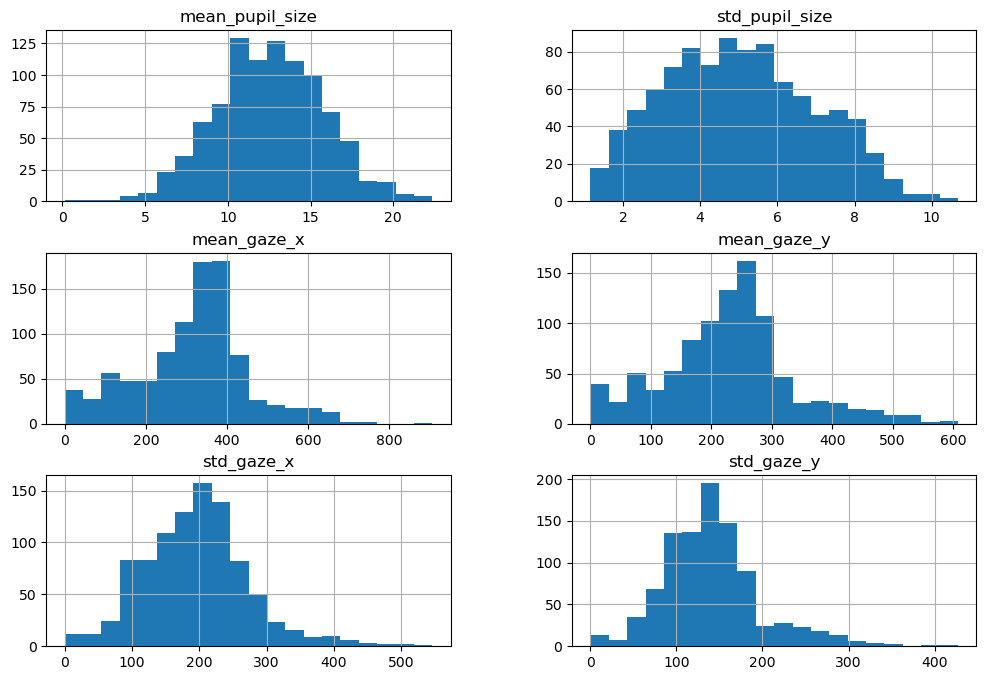

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numerical features for plotting
features_to_plot = ["mean_pupil_size", "std_pupil_size", "mean_gaze_x", "mean_gaze_y", "std_gaze_x", "std_gaze_y"]
df[features_to_plot].hist(bins=20, figsize=(12, 8))
plt.show()
